# High Level Inference

In this tutorial we will detail how a configuration file can currently be specified to run analysis without having to intimately deal with the `GammaBayes` code.

What we will be working up to is the following.

In [1]:
from gammabayes.high_level_inference.multipleobservations.inference import High_Level_Analysis
from gammabayes import GammaBinning
from astropy import units as u
import numpy as np

np.random.seed(42)  # Set the random seed


true_energy_axis = np.logspace(-1, 2, 61)*u.TeV
recon_energy_axis = np.logspace(-1, 2, 31)*u.TeV


true_lon_axis = np.linspace(-3, 3, 19)*u.deg
recon_lon_axis = np.linspace(-3, 3, 19)*u.deg

true_lat_axis = np.linspace(-3, 3, 16)*u.deg
recon_lat_axis = np.linspace(-3, 3, 16)*u.deg



high_level_thingy = High_Level_Analysis(
    true_binning_geometry=GammaBinning(energy_axis=true_energy_axis, lon_axis=true_lon_axis, lat_axis=true_lat_axis),
    recon_binning_geometry=GammaBinning(energy_axis=recon_energy_axis, lon_axis=recon_lon_axis, lat_axis=recon_lat_axis),
    pointing_dirs=[
        np.array([-2, 0.2])*u.deg,
        np.array([0, 0.2])*u.deg,
        np.array([2, -0.2])*u.deg,
        ],
    observation_times=[5*u.hr, 0.5*u.hr, 5*u.hr],
    mixture_layout= [
        {'DM': 
         ['ZZ DM Class', 'W+W- DM Class', 'HH DM Class', 'tt DM Class', 
        ]},
        #  'FG_HS_CCR'
        {'bkg': ['CCR_BKG', 'FermiGaggeroDiffusePrior', 'HESSCatalogueSources_Prior']}
        ],
    prior_parameter_specifications={},
    shared_parameter_specifications={'mass':
    [
      ['ZZ DM Class', 'W+W- DM Class', 'HH DM Class', 'tt DM Class', 
        ],
      
      {
        'name': 'mass',
        'discrete': True,
        'scaling': 'log10',
        'bounds': 'event_dynamic',
        'absolute_bounds': [1.2e-1, 8e1],
        'parameter_type': 'spectral_parameters',
        'dynamic_multiplier': 6,
        'num_events': 1e0,
        'default_value': 10.,
        'bins': 121}
    ]},

    mixture_parameter_specifications={
        'ZZ DM Class':
            {'discrete': False,
            'bounds': [0., 1.],
            'dependent': ['W+W- DM Class', 'HH DM Class',  'tt DM Class', 
            ],
            'custom_dist_name': 'dirichlet',
            'custom_dist_kwargs': 
                {'alpha': [
                    1., 
                    1., 
                    1., 
                    1.,
                    ],}},
        'W+W- DM Class':{},
        'HH DM Class': {},
        'tt DM Class': {},
        'DM':
            {'discrete': False,
            'bounds': [0., 1.],
            'dependent': ['bkg'],
            'custom_dist_name': 'dirichlet',
            'custom_dist_kwargs': 
                {'alpha': [
                    1., 
                    1.]}},

        'bkg': {},

        'CCR_BKG':
            {'discrete': False,'bounds': [0., 1.],
            'dependent': ['FermiGaggeroDiffusePrior', 'HESSCatalogueSources_Prior'],
            'custom_dist_name': 'dirichlet', 'custom_dist_kwargs': {'alpha': [ 1., 1.,1.]}},

        'FermiGaggeroDiffusePrior':{},

        'HESSCatalogueSources_Prior':{},
        },
    dark_matter_model_specifications={
        'dark_matter_density_profile':'Einasto_Profile',
        'dark_matter_mass':10.0*u.TeV,
        'DM_Channels':['W+W-', 'ZZ', 'HH', 'tt'],

    },
    observational_prior_models=['DM', 
        # FG_HS_CCR,
        'CCR_BKG',
        'FermiGaggeroDiffusePrior',
        'HESSCatalogueSources_Prior',
        ],
    true_mixture_specifications={
        'true_mixture_fractions':{
            'DM':                           0.5,
            'bkg':                          0.5,
            'CCR_BKG':                      1/3, #0.983,
            'FermiGaggeroDiffusePrior':     1/3, #0.011,
            'HESSCatalogueSources_Prior':   1/3, #0.006,
        },
        
        'DM_Annihilation_Ratios':
            {'ZZ DM Class':                        1/4,
            'W+W- DM Class':                       1/4,
            'HH DM Class':                         1/4,
            'tt DM Class':                         1/4}
    },
    skip_irf_norm_setup = True
    

)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/core/parameter_class.py:75: UserWarning: No bounds given. Defaulting to 0. and 1.
  warnings.warn("No bounds given. Defaulting to 0. and 1.")


__________ MIXTURE TREE STRUCTURE __________
note: if 'True' values have been unspecified, 
then the tree node values are the defaults such that if you add them up for their given branch you get 1.



So we'll split this information into three, information about: the observations, the source models and the inference parameter specifications. 

## Observation Info

First we need to define the range of the true and reconstructed energy, longitude and latitude axes and their resolutions. Typically we choose the reconstructed to have a lower resolution than the 'true' as the true values should have infinite precision, but we bin them for the sake of analysis. While the reconstructed bins don't provide much more information once they have a higher resolution than either the energy dispersion or point spread function dictate.

In [2]:
true_energy_axis = np.logspace(-1, 2, 61)*u.TeV
recon_energy_axis = np.logspace(-1, 2, 31)*u.TeV


true_lon_axis = np.linspace(-2, 2, 16)*u.deg
recon_lon_axis = np.linspace(-2, 2, 16)*u.deg

true_lat_axis = np.linspace(-2, 2, 21)*u.deg
recon_lat_axis = np.linspace(-2, 2, 21)*u.deg


For this demonstration we will choose to do three observations along the Galactic Plane at galactic longitude and latitude values of (-1.2, 0), (0, 0) [the Galactic Plane], and (1.2, 0) for 5, 50 and 5 hours respectively. Then from this we want 2400 events. We could feasibly just use the normalisations of the sources to dictate the number of events, but by doing this we don't have to worry about normalisation issues between sources.

In [3]:
true_binning_geometry=GammaBinning(energy_axis=true_energy_axis, lon_axis=true_lon_axis, lat_axis=true_lat_axis)
recon_binning_geometry=GammaBinning(energy_axis=recon_energy_axis, lon_axis=recon_lon_axis, lat_axis=recon_lat_axis)
pointing_dirs=[
    np.array([-1.2, 0.])*u.deg,
    np.array([0, 0.])*u.deg,
    np.array([1.2, 0.])*u.deg,
    ]
observation_times=[5*u.hr, 50*u.hr, 5*u.hr]

total_events = 2400

## Source Model Information

We then want to define all the required model information. We will first define the base model names that we wish to investigate, in our case we are using the pre-defined models within the `GammaBayes` package `CCR_BKG`, `FermiGaggeroDiffusePrior` and `HESSCatalogueSources_Prior` for our backgrounds to a dark matter or `DM` model.

In [4]:
observational_prior_models=['DM', 
    # FG_HS_CCR,
    'CCR_BKG',
    'FermiGaggeroDiffusePrior',
    'HESSCatalogueSources_Prior',
    ]

We will then define the specifics of the dark matter model. Currently, you can specify a `dark_matter_density_profile` to be `Einasto_Profile`, `NFW_Profile` or `Burkert_Profile`. 

The spectral profile can either be a specific model which you specify via the `dark_matter_spectral_model` kwarg in the below dictionary of either `Z2_ScalarSinglet` or `Z5`, or you can specify the channels which you wish to investigate independent of a dark matter physics model. 

For this tutorial we choose to investigate the channels which are specified as below.

We also define the dark matter mass to be 10 TeV, if a mass isn't provided it will not run properly. This hasn't been thoroughly tested as use cases so far always specify the dark matter mass.

In [5]:
dark_matter_model_specifications={
    'dark_matter_density_profile':'Einasto_Profile',
    'dark_matter_mass':10.0*u.TeV,
    'DM_Channels':['ZZ', 'W+W-', 'HH', 'tt'],

}

We then want to define a structure for how we wish to construct the mixture of all these models/priors. This is done via the `mixture_layout` variable which is made to mimic the below figure.

!["Figures/mixture_tree.png"](Figures/mixture_tree.png)

In [6]:
mixture_layout= [
    {'DM': 
        [ 'ZZ DM Class', 'W+W- DM Class', 'HH DM Class', 'tt DM Class', 
    ]},
    #  'FG_HS_CCR'
    {'bkg': ['CCR_BKG', 'FermiGaggeroDiffusePrior', 'HESSCatalogueSources_Prior']}
    ]


We then specify the values associated with each of the above nodes/branches. For the specific case of dark matter we specify the values through the `DM_Annihilation_Ratios` kwarg.


In [7]:
true_mixture_specifications={
    'true_mixture_fractions':{
        'DM':                           0.5, # 50% of the events go to dark matter
        'bkg':                          0.5, # 50% of the events go to the backgrounds
        'CCR_BKG':                      1/3, # 1/3 of the background events go to the CCR background
        'FermiGaggeroDiffusePrior':     1/3, # 1/3 of the background events go to the diffuse background
        'HESSCatalogueSources_Prior':   1/3, # 1/3 of the background events go to the localised background
    },
    
    'DM_Annihilation_Ratios':
        {'W+W- DM Class':               1/4, # 1/4 of the background events go to the W bosons Channel
        'ZZ DM Class':                  1/4, # 1/4 of the background events go to the Z boson Channel
        'HH DM Class':                  1/4, # 1/4 of the background events go to the Higgs Channel
        't+t- DM Class':                1/4, # 1/4 of the background events go to the top quark Channel
        }
}

## Inference Parameter Specifications

We now need to specify what parameters we wish to investigate, and how we are going to investigate them.

We would first want to define unique parameters for the priors following the order Prior Name>'spectral_parameters'/'spatial_parameters'>name of parameter>parameter information or Prior Name>name of parameter>parameter information (including whether it is either 'spectral' or 'spatial'). For this tutorial we don't have any parameters unique to a specific prior so this variable is empty.

In [8]:
prior_parameter_specifications={}

# Example for reference

# prior_parameter_specifications={
    # 'ZZ DM Class': # Prior name
    # {'spectral_parameters': # Parameter type
    #   { # Parameter information
    #     'name': 'mass',
    #     'discrete': True,
    #     'scaling': 'log10',
    #     'bounds': 'event_dynamic',
    #     'absolute_bounds': [1.2e-1, 8e1],
    #     'parameter_type': 'spectral_parameters',
    #     'dynamic_multiplier': 6,
    #     'num_events': 1e0,
    #     'default_value': 10.,
    #     'bins': 121},
    #  },
    # }
                                        

Now we specify parameters that are shared across multiple priors. In this case all the dark matter channels share the same mass parameter (we wouldn't want to fit a dark matter model where every channel is associated with a different dark matter mass). The format for this can be followed from the below cell.

In [9]:
shared_parameter_specifications={'mass':
                                 [
                                     ['ZZ DM Class', 'W+W- DM Class', 'HH DM Class', 'tt DM Class', ], #Names of priors that share this parameter
                                     { # Parameter information dictionary
                                        'name': 'mass',
                                        'discrete': True,
                                        'scaling': 'log10',
                                        'bounds': 'event_dynamic',
                                        'absolute_bounds': [1e0, 2e1],
                                        'parameter_type': 'spectral_parameters',
                                        'dynamic_multiplier': 6,
                                        'num_events': 1e0,
                                        'default_value': 10.,
                                        'bins': 121}
                                        ]
}

Now, for every mixture fraction that we defined above, we wish to explore the parameter space of. We will define all the mixture parameters to follow a Dirichlet prior with uninformative alpha values (although in this case they happen to match what we've chosen for our weights). Once you define a mixture parameters dependencies you don't have to define the same thing for the other parameters, just that they are included, which is why many below are simply a name and then an empty dictionary.

In [10]:
mixture_parameter_specifications={
        'ZZ DM Class':
            {'discrete': False,
            'bounds': [0., 1.],
            'dependent': ['W+W- DM Class', 'HH DM Class',  'tt DM Class', 
            ],
            'custom_dist_name': 'dirichlet',
            'custom_dist_kwargs': 
                {'alpha': [
                    1., 
                    1., 
                    1., 
                    1.,
                    ],}},
        'W+W- DM Class': {'discrete': False, 'bounds':[0,1]},
        'HH DM Class': {'discrete': False, 'bounds':[0,1]},
        'tt DM Class': {'discrete': False, 'bounds':[0,1]},



        'DM':
            {'discrete': False,
            'bounds': [0., 1.],
            'dependent': ['bkg'],
            'custom_dist_name': 'dirichlet',
            'custom_dist_kwargs': 
                {'alpha': [
                    1., 
                    1.]}},

        'bkg': {'discrete': False, 'bounds':[0,1]},



        'CCR_BKG':
            {'discrete': False,'bounds': [0., 1.],
            'dependent': ['FermiGaggeroDiffusePrior', 'HESSCatalogueSources_Prior'],
            'custom_dist_name': 'dirichlet', 'custom_dist_kwargs': {'alpha': [ 1., 1.,1.]}},

        'FermiGaggeroDiffusePrior':{'discrete': False, 'bounds':[0,1]},

        'HESSCatalogueSources_Prior':{'discrete': False, 'bounds':[0,1]},
        }

Now we have all the information we require and can chuck it into the high level analysis class. It may take a couple minutes, it has a bit of work to do.

In [11]:
high_level_thingy = High_Level_Analysis(
    true_binning_geometry=true_binning_geometry,
    recon_binning_geometry=recon_binning_geometry,
    pointing_dirs=pointing_dirs,
    observation_times=observation_times,
    mixture_layout= mixture_layout,
    prior_parameter_specifications=prior_parameter_specifications,
    shared_parameter_specifications=shared_parameter_specifications,

    mixture_parameter_specifications=mixture_parameter_specifications,
    dark_matter_model_specifications=dark_matter_model_specifications,
    observational_prior_models=observational_prior_models,
    true_mixture_specifications=true_mixture_specifications,
    
)

ic| base_pointing_dir: <Quantity [0., 0.] deg>


__________ MIXTURE TREE STRUCTURE __________
note: if 'True' values have been unspecified, 
then the tree node values are the defaults such that if you add them up for their given branch you get 1.



Filling in buffer: 100%|██████████| 61/61 [00:19<00:00,  3.17it/s]


## The cool stuff

Now we need to follow three basic methods to do everything else we want. 

We perform the required simulations using `simulation_observation_set`. If you get an error like,
`ValueError: Number of samples, -2147483648, must be non-negative.` 
then your true value spatial axis have a bin at 0 which is currently in issue with how we are calculating our differential J factors.

In [12]:
obs_containers = high_level_thingy.simulation_observation_set(Nevents=900)

ic| event_counts: {'CCR_BKG': 14342,
                   'FermiGaggeroDiffusePrior': 145,
                   'HESSCatalogueSources_Prior': 264,
                   'HH DM Class': 171524838253724758105969917952,
                   'W+W- DM Class': 161907188235191393700703895552,
                   'ZZ DM Class': 152540387894319893100693028864,
                   'tt DM Class': 159571772745771077197988102144}
100%|██████████| 3/3 [00:31<00:00, 10.48s/it]


We can then pass these container to the `run_nuisannce_marg` method to get our log marginalised probabilities.

In [13]:
# high_level_thingy._setup_irf_norm(irf_loglike = high_level_thingy.observation_cube.observations[0].irf_loglike)

all_log_marg_results = high_level_thingy.run_nuisance_marg(observation_containers=obs_containers)

Setting up prior matrices:  43%|████▎     | 3/7 [00:07<00:09,  2.40s/it]ic| log_prior_matrices.shape: (61, 16, 21, 121)


These results are for each individual observation, so we need to combine them.

In [14]:
combine_log_marg_results = high_level_thingy.combine_log_marg_results(disconnected_log_marg_results=all_log_marg_results)

In [15]:
high_level_thingy.setup_hyperparam_analysis(
                                  combined_log_marg_results=combine_log_marg_results,
                                  observation_containers=obs_containers)

Number of event weights: 797


Instantiating sampling class....


In [16]:
sampler = high_level_thingy.run_hyper()

4977it [14:36,  5.68it/s, +500 | bound: 807 | nc: 1 | ncall: 1832303 | eff(%):  0.299 | loglstar:   -inf < 2126.231 <    inf | logz: 2116.932 +/-  0.137 | dlogz:  0.001 >  0.509]


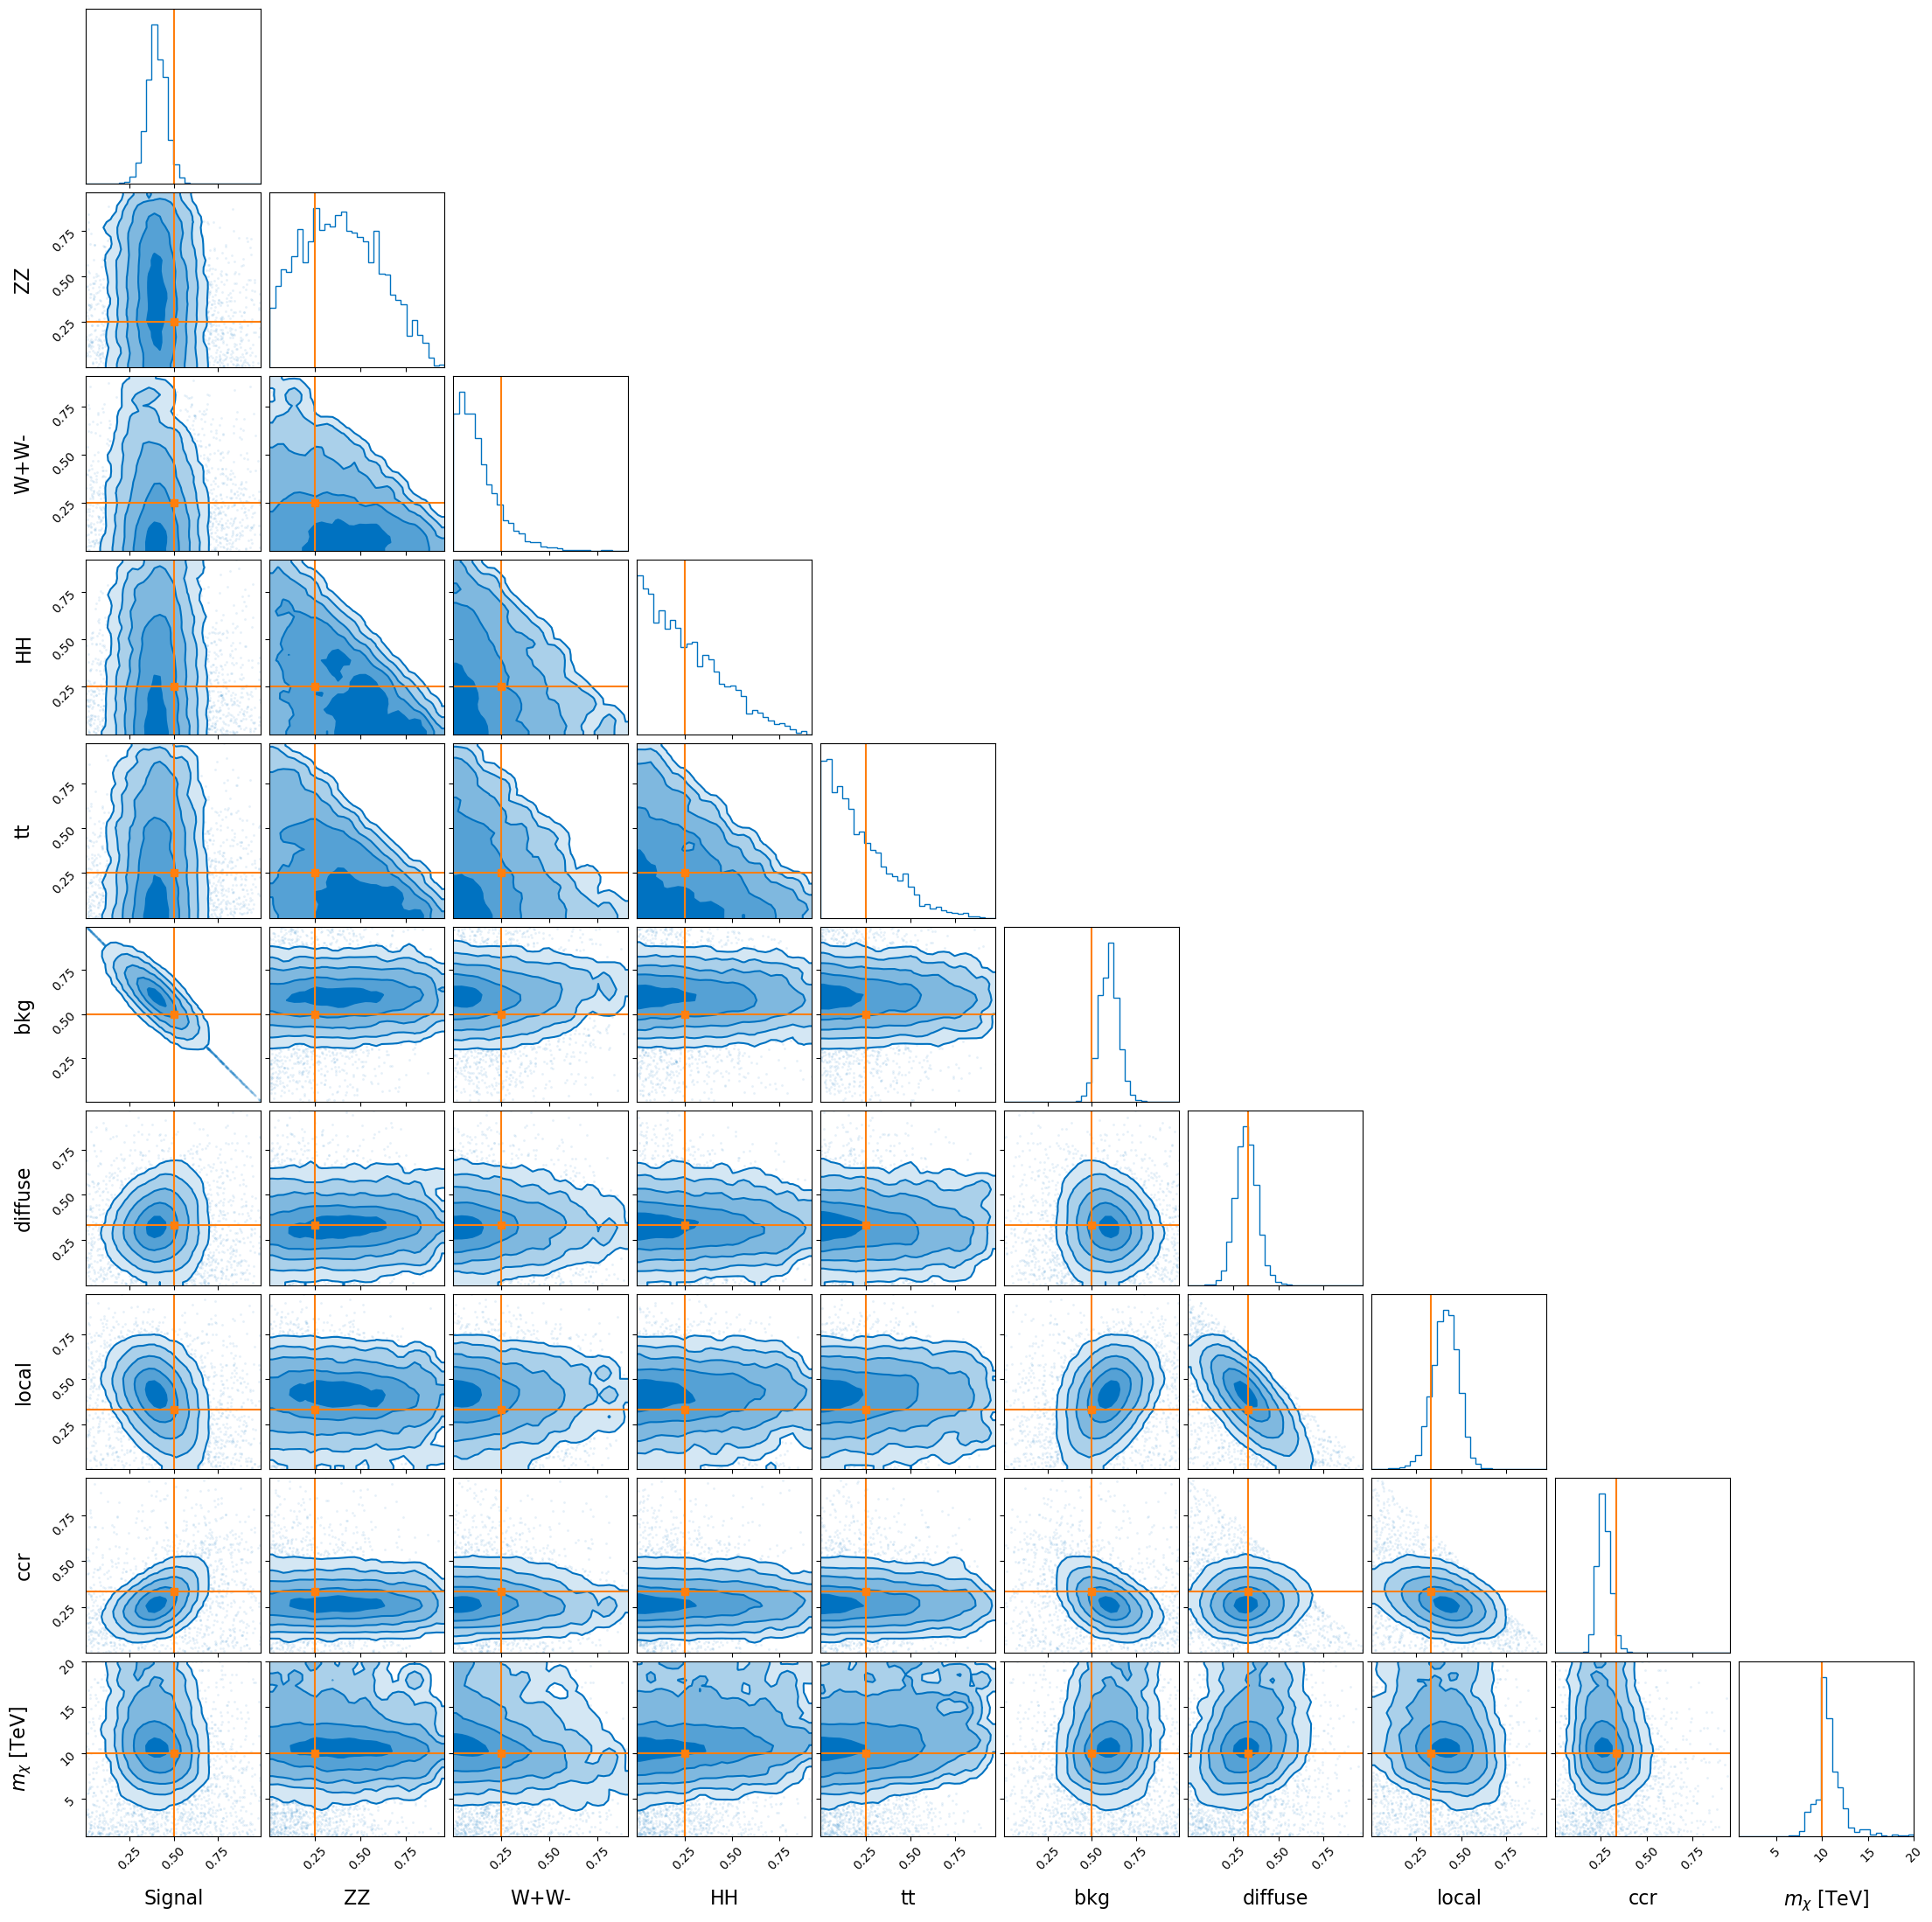

In [17]:
from corner import corner
from gammabayes.utils.plotting import defaults_kwargs
from matplotlib import pyplot as plt

sampler_results = sampler.results
defaults_kwargs['smooth'] = 0.9
corner(sampler_results.samples,
       weights=np.exp(sampler_results.logwt-np.mean(sampler_results.logwt)), 
       labels=['Signal', 'ZZ', 'W+W-','HH', 'tt', 'bkg', 'diffuse', 'local', 'ccr', r'$m_\chi$ [TeV]'],
       bins=32,
       truths=[true_mixture_specifications['true_mixture_fractions']['DM'], 
               *true_mixture_specifications['DM_Annihilation_Ratios'].values(),
               *list(true_mixture_specifications['true_mixture_fractions'].values())[1:], 
               dark_matter_model_specifications['dark_matter_mass'].value]
               ,
       **defaults_kwargs)
plt.show()